In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
# Read mnist data from the mat file
mnist_data = scipy.io.loadmat("mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])
# print(np.shape(imgs_train))
# print(np.shape(imgs_test))
print(np.shape(labels_train))
print(np.shape(labels_test))
# print(labels_train[:100])
d1,d2,N = np.shape(imgs_train)

(60000,)
(10000,)


In [3]:
# Select images of 1 and 7
Itrain_1 = np.where(labels_train == 1)
Itrain_7 = np.where(labels_train == 7)
Itest_1 = np.where(labels_test == 1)
Itest_7 = np.where(labels_test == 7)
imgs_train_1 = np.squeeze(imgs_train[:,:,Itrain_1])
imgs_train_7 = np.squeeze(imgs_train[:,:,Itrain_7])
imgs_test_1 = np.squeeze(imgs_test[:,:,Itest_1])
imgs_test_7 = np.squeeze(imgs_test[:,:,Itest_7])
Ntrain_1 = np.size(Itrain_1)
Ntrain_7 = np.size(Itrain_7)
Ntest_1 = np.size(Itest_1)
Ntest_7 = np.size(Itest_7)
print(f"Ntrain_1 = {Ntrain_1}, Ntrain_7 = {Ntrain_7}")
print(f"Ntest_1 = {Ntest_1}, Ntest_7 = {Ntest_7}")

Ntrain_1 = 6742, Ntrain_7 = 6265
Ntest_1 = 1135, Ntest_7 = 1028


In [4]:
# Use PCA to reduce the dimensionality to nPCA
NPCA = 20

dd = d1*d2
X1 = np.zeros((Ntrain_1,dd))
X7 = np.zeros((Ntrain_7,dd))
for j in range(Ntrain_1):
    img = np.squeeze(imgs_train_1[:,:,j])
    X1[j,:] = np.reshape(img,(dd,))
for j in range(Ntrain_7):
    img = np.squeeze(imgs_train_7[:,:,j])
    X7[j,:] = np.reshape(img,(dd,))
X = np.concatenate((X1,X7),axis = 0)
# print(np.shape(X))
U,S,Vtrans = np.linalg.svd(X,full_matrices = False)
# print(f"U: {np.shape(U)}; S: {np.shape(S)}; Vtrans: {np.shape(Vtrans)}")
V = np.transpose(Vtrans)
Xtrain = np.matmul(X,V[:,:NPCA])
print(f"Xtrain: {np.shape(Xtrain)}")

Xtrain: (13007, 20)


In [5]:
# Prepare the test set
X1test = np.zeros((Ntest_1,dd))
X7test = np.zeros((Ntest_7,dd))
for j in range(Ntest_1):
    img = np.squeeze(imgs_test_1[:,:,j])
    X1test[j,:] = np.reshape(img,(dd,))
for j in range(Ntest_7):
    img = np.squeeze(imgs_test_7[:,:,j])
    X7test[j,:] = np.reshape(img,(dd,))
Xtest = np.concatenate((X1test,X7test),axis = 0)
Xtest = np.matmul(Xtest,V[:,:NPCA])
print(f"Xtest: {np.shape(Xtest)}")

Xtest: (2163, 20)


In [6]:
# prepare labels for the train and test sets: ones have label 1, sevens have label -1
Ntrain = Ntrain_1 + Ntrain_7
Ntest = Ntest_1 + Ntest_7
lbl_train = np.ones((Ntrain,))
lbl_train[Ntrain_1:] = -1
lbl_test = np.ones((Ntest,))
lbl_test[Ntest_1:] = -1

In [7]:
# Define functions for finding the optimal dividing surface
def logloss_quadratic(X,y,w):
    return 0.5*np.sum((np.log(1. + np.exp(-myquadratic(X,y,w))))**2)

def Res_and_Jac(X,y,w):
    # the vector of residuals r
    aux = np.exp(-myquadratic(X,y,w))
    r = np.log(1. + aux)
    # the Jacobian matrix J[i,j] = dr[i]/dx[j]
    a = -aux/(1. + aux)
    n,d = np.shape(X)
    d2 = d*d
    ya = y*a
    qterm = np.zeros((n,d2))
    for k in range(n):
        xk = X[k,:]
        xx = np.outer(xk,xk)
        qterm[k,:] = np.reshape(xx,(np.size(xx),))
    J = np.concatenate((qterm,X,np.ones((n,1))),axis = 1)   
    for k in range(n):
        J[k,:] = J[k,:]*ya[k]
    return r,J

def myquadratic(X,y,w):
    d = np.size(X,axis = 1)
    d2 = d*d
    W = np.reshape(w[:d2],(d,d))
    v = w[d2:d2+d];
    b = w[-1]
    qterm = np.diag(X@W@np.transpose(X))
    q = y*qterm + (np.outer(y,np.ones((d,)))*X)@v + y*b
    return q

In [8]:
def Loss(r):
    return 0.5 * np.sum(r ** 2)  # 0.5*sum(r^2)

def Nesterov(Res_and_Jac, x, ITER_MAX, TOL):
    # r, J = Res_and_Jac(x)
    # n, d = np.shape(J)
    lossvals = np.zeros(ITER_MAX)
    gradnormvals = np.zeros(ITER_MAX)
    # lossvals[0] = Loss(r)
    # grad = np.matmul(J.T, r)  # grad = J^\top r

    # Bmatr = np.matmul(J.T, J)  # Bmatr = J^\top J
    # gradnorm = np.linalg.norm(grad)
    # gradnormvals[0] = gradnorm
    # print("iter 0: loss = ", lossvals[0], " gradnorm = ", gradnorm)
    # start iterations
    iter = 0
    xold = x #todo fix initialization
    alpha=0.3
    improvement = 1
    while  iter < ITER_MAX and improvement >0.01: #gradnorm > TOL and
        #nesterov
        mu=1-(3/(5+iter))
        # y = (1+mu) * x - mu * xold
        # r_y, J_y = Res_and_Jac(y) #todo
        # grad_y = np.matmul(J_y.T, r_y) #todo
        # print('norm:', np.linalg.norm(grad_y))
        
        v=x-xold
        r_y, J_y = Res_and_Jac(x+ mu*v) #todo
        grad_y = np.matmul(J_y.T, r_y) #todo
        v=mu*v-alpha*grad_y/np.linalg.norm(grad_y)
        xold = x
        x=x+v
        # x = y- alpha * grad_y/np.linalg.norm(grad_y) #todo change 1 to alpha
        # r, J = Res_and_Jac(x)
        lossnew = Loss(x)
        # grad = np.matmul(J.T, r)
        gradnorm = np.linalg.norm(grad_y)
        lossvals[iter] = lossnew
        gradnormvals[iter] = gradnorm
        # print(f"LM, iter #{iter}: loss = {lossvals[iter]:.4e}, improvement = {improvement:.4e}") #, gradnorm = {gradnorm:.4e}")
        if iter >= 1:
            improvement = lossvals[iter-1]-lossvals[iter]
        iter = iter + 1
        
    print(f"Nesterov, iter #{iter-1}: loss = {lossvals[iter-1]:.4e}, gradnorm = {gradnorm:.4e}")
    return x, iter, lossvals[0:iter], gradnormvals[0:iter]

In [9]:
#nesterov stochastic

def NesterovStoc(Xtrain,lbl_train, x, ITER_MAX, TOL, batch_size=1000, step=1):
    Xtrain=Xtrain[0:13000]
    lbl_train=lbl_train[0:13000]
    # r, J = Res_and_Jac(x)
    # n, d = np.shape(J)
    lossvals = np.zeros(ITER_MAX)
    gradnormvals = np.zeros(ITER_MAX)
    # lossvals[0] = Loss(r)
    # grad = np.matmul(J.T, r)  # grad = J^\top r

    # Bmatr = np.matmul(J.T, J)  # Bmatr = J^\top J
    # gradnorm = np.linalg.norm(grad)
    # gradnormvals[0] = gradnorm
    # print("iter 0: loss = ", lossvals[0], " gradnorm = ", gradnorm)
    # start iterations
    iter = 0
    idx = 0
    xold = x #todo fix initialization
    alpha=0.1
    improvement = 1
    gradnorm = 1
    while gradnorm > TOL and iter < ITER_MAX and improvement >0.01: #
        #nesterov
        permutation = np.random.permutation(Xtrain.shape[0])
        Xtrain_shuffled = Xtrain[permutation]
        lbl_train_shuffled = lbl_train[permutation]
        for i in range(0, Xtrain.shape[0], batch_size):
            X_batch = Xtrain_shuffled[i:i+batch_size]
            lbl_batch = lbl_train_shuffled[i:i+batch_size]
            
            
            mu=1-(3/(5+idx))
            # y = (1+mu) * x - mu * xold
            # r_y, J_y = Res_and_Jac(X_batch,lbl_batch,y) #todo
            # grad_y = np.matmul(J_y.T, r_y) #todo
            # print('norm:', np.linalg.norm(grad_y))
            v=x-xold
            r_y, J_y = Res_and_Jac(X_batch,lbl_batch,x+ mu*v) #todo
            grad_y = np.matmul(J_y.T, r_y) #todo
            v=mu*v-alpha*grad_y/np.linalg.norm(grad_y)
            xold = x
            x=x+v
            # xold = x
            # x = y- 0.3 * grad_y/np.linalg.norm(grad_y) #todo change 1 to alpha
            # print('test_norm:', alpha * np.linalg.norm(grad_y))
    
            # r, J = Res_and_Jac(x)
            lossnew = Loss(x)
            # grad = np.matmul(J.T, r)
            gradnorm = np.linalg.norm(grad_y)
            # print('gradnorm:', gradnorm)
            lossvals[idx] = lossnew
            gradnormvals[iter] = gradnorm
        
        if idx >=1:
             improvement = lossvals[idx-1]-lossvals[idx]
        idx += 1
        # print(f"LM, iter #{iter}: loss = {lossnew:.4e}, improvement = {improvement:.4e}") #, gradnorm = {gradnorm:.4e}")
        iter = iter + 1
        
    print(f"Stochastic Nesterov, iter #{iter-1}: loss = {lossvals[iter-1]:.4e}, gradnorm = {gradnorm:.4e}")
    return x, iter, lossvals[0:iter], gradnormvals[0:iter]

In [10]:

def Adam(Res_and_Jac, x, ITER_MAX, TOL):
    # print('x_norm:', np.linalg.norm(x))
    alpha=0.1
    beta1=0.9
    beta2=0.999
    epsilon=1e-6

    r, J = Res_and_Jac(x)
    n, d = np.shape(J)
    lossvals = np.zeros(ITER_MAX)
    gradnormvals = np.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    grad = np.matmul(J.T, r)  # grad = J^\top r

    Bmatr = np.matmul(J.T, J)  # Bmatr = J^\top J
    gradnorm = np.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    # print("iter 0: loss = ", lossvals[0], " gradnorm = ", gradnorm)
    # start iterations
    iter = 1
    i=9
    # m = np.zeros(len(x)) 
    # v = np.zeros(len(x))
    m=0
    v=0
    improvement = 1
    while gradnorm > TOL and iter < ITER_MAX and improvement >0.1:
        m = beta1 * m + (1 - beta1) * grad[i]
        v = beta2 * v + (1 - beta2) * (grad ** 2)[i]
        m_hat = m / (1 - beta1 ** iter)
        v_hat = v / (1 - beta2 ** iter)
        
        x = x- alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # print('x_norm:', np.linalg.norm(x))
        r, J = Res_and_Jac(x)
        lossnew = Loss(x)
        grad = np.matmul(J.T, r)
        gradnorm = np.linalg.norm(grad)

        lossvals[iter] = lossnew
        gradnormvals[iter] = gradnorm
        # print(f"LM, iter #{iter}: loss = {lossvals[iter]:.4e}, gradnorm = {gradnorm:.4e}")
        iter = iter + 1
        improvement = lossvals[iter-1]-lossvals[iter]

    print(f"Adam, iter #{iter-1}: loss = {lossvals[iter-1]:.4e}, gradnorm = {gradnorm:.4e}")
    return x, iter, lossvals[0:iter], gradnormvals[0:iter]

In [11]:

def AdamStoc(Xtrain,lbl_train, x, ITER_MAX, TOL, batch_size=6500, step=1):
    # print('x_norm:', np.linalg.norm(x))
    Xtrain=Xtrain[0:13000]
    lbl_train=lbl_train[0:13000]
    alpha=0.05
    beta1=0.9
    beta2=0.999
    epsilon=1e-6

    r, J = Res_and_Jac(Xtrain,lbl_train,x)
    n, d = np.shape(J)
    lossvals = np.zeros(ITER_MAX)
    gradnormvals = np.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    grad = np.matmul(J.T, r)  # grad = J^\top r

    Bmatr = np.matmul(J.T, J)  # Bmatr = J^\top J
    gradnorm = np.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    # print("iter 0: loss = ", lossvals[0], " gradnorm = ", gradnorm)
    # start iterations
    iter = 1 #todo 0
    idx=1
    # m = np.zeros(len(x)) 
    # v = np.zeros(len(x))
    m=0
    v=0
    i=9
    improvement = 1
    flag=0
    lossnew=1
    while gradnorm > TOL and iter < ITER_MAX and lossnew > 0.001:# and improvement >0.01:
        permutation = np.random.permutation(Xtrain.shape[0])
        Xtrain_shuffled = Xtrain[permutation]
        lbl_train_shuffled = lbl_train[permutation]
        for j in range(0, Xtrain.shape[0], batch_size):
            X_batch = Xtrain_shuffled[i:i+batch_size]
            lbl_batch = lbl_train_shuffled[i:i+batch_size]
            
            m = beta1 * m + (1 - beta1) * grad[i]
            v = beta2 * v + (1 - beta2) * (grad** 2)[i]
            m_hat = m / (1 - beta1 ** idx)
            v_hat = v / (1 - beta2 ** idx)
            
            x = x- alpha * m_hat / (np.sqrt(v_hat) + epsilon)
            
            # print('x_norm:', np.linalg.norm(x))
            r, J = Res_and_Jac(X_batch,lbl_batch,x)
            lossnew = Loss(x)
            grad = np.matmul(J.T, r)
            gradnorm = np.linalg.norm(grad)
            # print(f"GN, iter #{idx}/ loss = {lossnew:.4e}, gradnorm = {gradnorm:.4e}")
    
            lossvals[idx] = lossnew
            gradnormvals[idx] = gradnorm
            
            if idx >2:
                improvement = lossvals[idx-1]-lossvals[idx]
                
            if lossnew < 0.001: #improvement < 0.01:
                # print('improvement:', improvement)
                break
                # flag=1
            idx += 1
            # if np.linalg.norm(grad) < TOL:
            #     break
        # if flag == 1:
        #     break
        iter = iter + 1
        
        # print(f"LM, iter #{iter}: loss = {lossnew:.4e}, gradnorm = {gradnorm:.4e}")


    print(f"Stochastic Adam, iter #{iter-1}: loss = {lossvals[iter-1]:.4e}, gradnorm = {gradnorm:.4e}")
    return x, iter, lossvals[0:iter], gradnormvals[0:iter]

In [12]:
def plot_all(y_axis, y_label, title):
    fig = plt.figure()
    plt.rcParams.update({'font.size': 16})
    plt.plot(y_axis)
    plt.title(title)
    plt.xlabel("Iteration #")
    plt.ylabel(y_label)
    plt.yscale("log")
    plt.show()

Nesterov, iter #53: loss = 1.6739e+02, gradnorm = 8.2334e+03


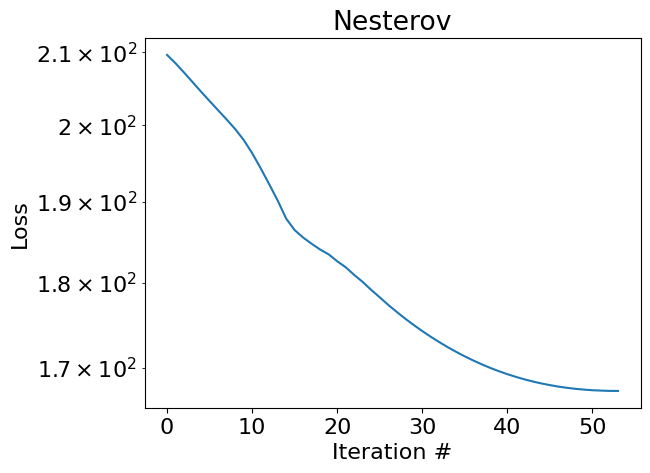

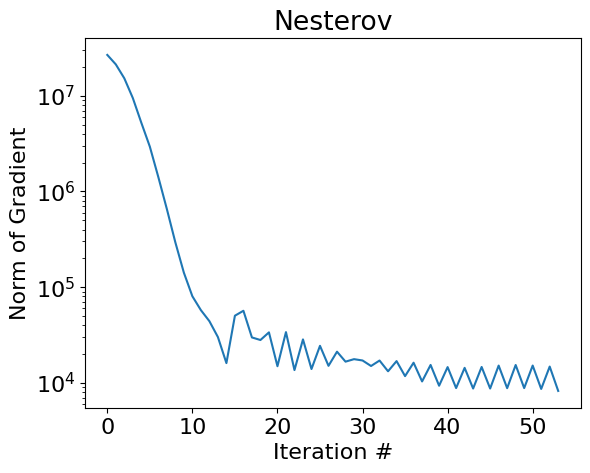

In [13]:
#Part(a) - Deterministic 
d = NPCA
def r_and_J(w):
    return Res_and_Jac(Xtrain,lbl_train,w)
# The quadratic surface is of the form x^\top W x + v x + b 
# The total number of parameters in W,v,b is d^2 + d + 1
# The initial guess: all parameters are ones
w = np.ones((d*d + d + 1,))
iter_max = 600
tol = 1e-3
w,Niter,Loss_vals,gradnorm_vals = Nesterov(r_and_J,w,iter_max,tol)
plot_all(Loss_vals, 'Loss', 'Nesterov')
plot_all(gradnorm_vals, 'Norm of Gradient', 'Nesterov')


Stochastic Nesterov, iter #24: loss = 1.4308e+02, gradnorm = 5.1928e+02


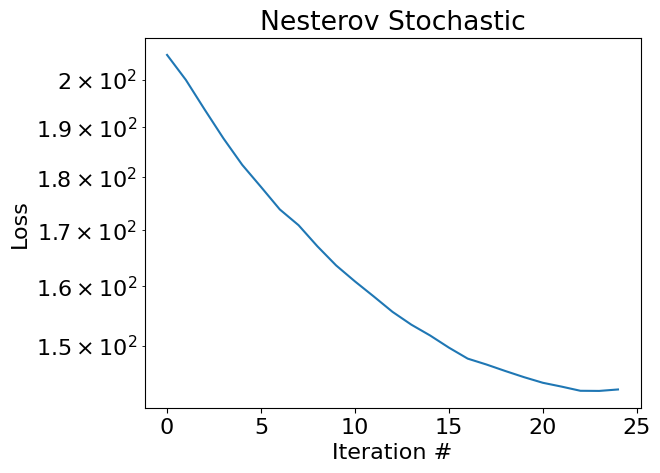

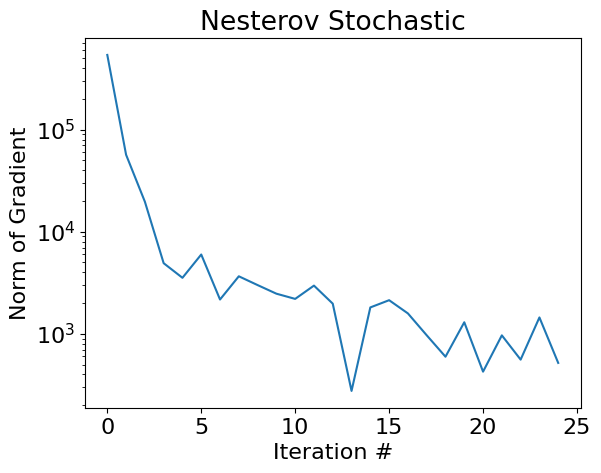

In [14]:
#Part(a) - Stochastic  
w = np.ones((d*d + d + 1,))
w,Niter,Loss_vals,gradnorm_vals = NesterovStoc(Xtrain,lbl_train,w,iter_max,tol)
plot_all(Loss_vals, 'Loss', 'Nesterov Stochastic')
plot_all(gradnorm_vals, 'Norm of Gradient', 'Nesterov Stochastic')

Adam, iter #11: loss = 4.6755e-03, gradnorm = 1.5109e+05


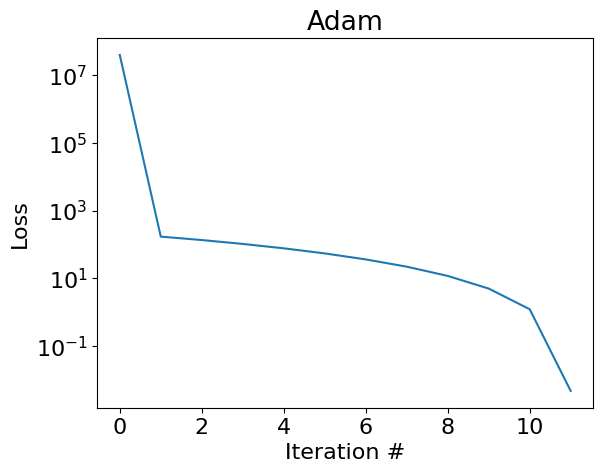

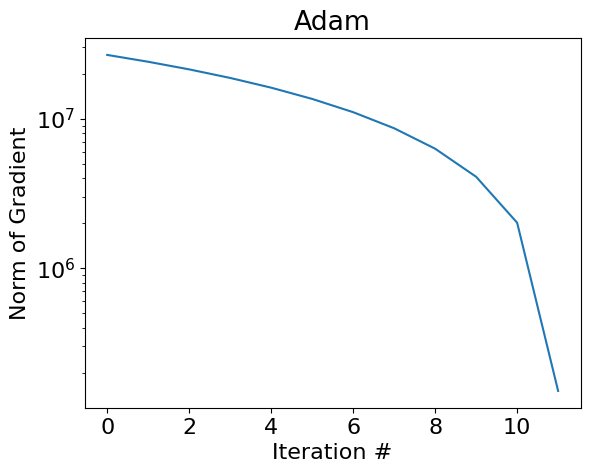

In [15]:
#Part(b) - Deterministic 
w = np.ones((d*d + d + 1,))
w,Niter,Loss_vals,gradnorm_vals = Adam(r_and_J,w,iter_max,tol)
plot_all(Loss_vals, 'Loss', 'Adam')
plot_all(gradnorm_vals, 'Norm of Gradient', 'Adam')

Stochastic Adam, iter #28: loss = 1.2701e-03, gradnorm = 4.4967e+04


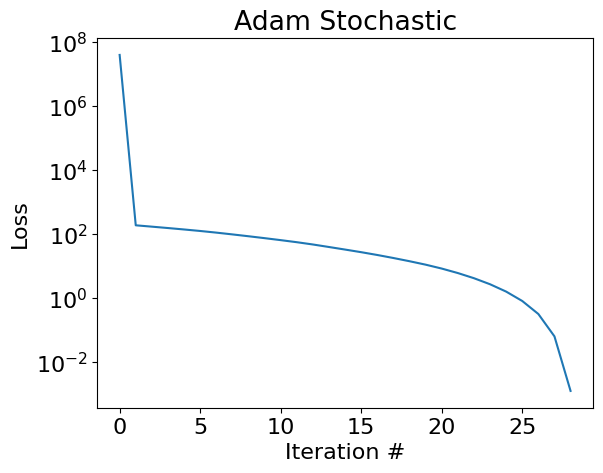

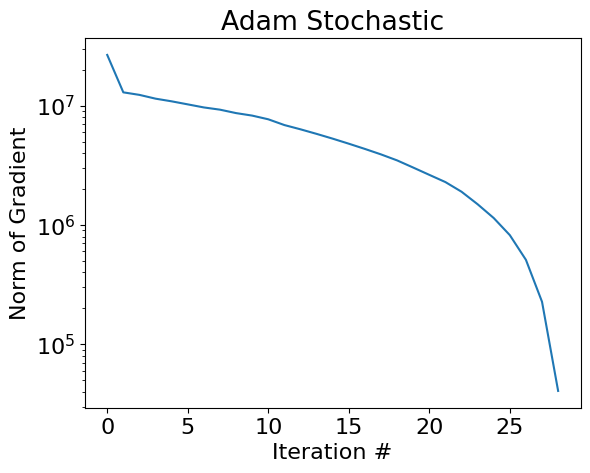

In [16]:
#Part(b) - Stochastic  
w = np.ones((d*d + d + 1,))
w,Niter,Loss_vals,gradnorm_vals = AdamStoc(Xtrain,lbl_train,w,iter_max,tol)
plot_all(Loss_vals, 'Loss', 'Adam Stochastic')
plot_all(gradnorm_vals, 'Norm of Gradient', 'Adam Stochastic')